In [498]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings

from datetime import datetime
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn import svm
from sklearn.metrics import mean_squared_error
from scipy.stats import shapiro
from sklearn import cluster
from scipy.cluster import vq

warnings.filterwarnings('ignore')
% config InlineBackend.figure_format = 'png'
% matplotlib inline

In [499]:
def read_data(filename):
    dataset = pd.read_csv(filename)
    return dataset

In [500]:
def evaluate_rmse(dataset, prediction):
    return np.sqrt(mean_squared_error(dataset['Revenue'], dataset[prediction]))

In [501]:
def parse_date(train):
    
    # Assume a date which is later than latest opening date of all the restaurants
    latest_date = datetime.strptime("01/01/2015", '%m/%d/%Y')
    
    open_num_days = []
    open_month = []
    open_year = []

    for date in train['Open Date']:
        cur_date = datetime.strptime(date, '%m/%d/%Y')
        open_num_days.append((latest_date - cur_date).days)
        open_month.append(cur_date.month)
        open_year.append(cur_date.year)

    train['Days'] = open_num_days
    train['Month'] = open_month
    train['Year'] = open_year

In [502]:
def adjust_type(data):
    
    # Augment data with id for original order of records
    data.loc[:, "tempIdx"] = data.index
    
    # Get records with restaurant type = "Mobile"
    query_matrix = data.loc[data.Type == "MB", :]
    
    # Get records with restaurant type != "Mobile"
    search_matrix = data.loc[data.Type != "MB", :]

    # Use only continuous features for classification
    features = data.columns.values[4:]

    # Predict known type using KNN
    clf = KNeighborsClassifier(n_neighbors=5)
    clf.fit(search_matrix.loc[:, features], search_matrix.loc[:, 'Type'])
    query_matrix.loc[:, 'Type'] = clf.predict(query_matrix.loc[:, features])
    
    # Construct data to original form and order
    data = pd.concat((search_matrix.loc[:, "Open Date" : "tempIdx"],
                      query_matrix.loc[:, "Open Date" : "tempIdx"]), ignore_index = True)
    data = data.sort_values(["tempIdx"])
    del data["tempIdx"]
    
    return data

In [503]:
def adjust_cities(data, train, k):
    
    # As found by box plot of each city's mean over each p-var
    relevant_pvars =  ["P1", "P2", "P11", "P19", "P20", "P23", "P30"]
    train = train.loc[:, relevant_pvars]
    
    # Optimal k is 20 as found by DB-Index plot    
    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit(train)
    
    # Get the cluster centers and classify city of each data instance to one of the centers
    # centroids = kmeans.cluster_centers_
    # data['City Cluster'] = vq.vq(data.loc[:, relevant_pvars], centroids)[0]
    data['City Cluster'] = kmeans.predict(data.loc[:, relevant_pvars])

    return data      

In [504]:
def random_forest(train_rf, test_rf):
    
    rf = RandomForestRegressor()
    
    rf.fit(train_rf.loc[:, "P1" : "Other"], train_rf.loc[:, "Revenue"])
    test_rf["Predicted_rf"] = rf.predict(test_rf.loc[:, "P1" : "Other"])
    
    return rf

In [505]:
def svm_regressor(train_svm, test_svm):
 
    # one vs many regresion classifier
    lin_clf = svm.LinearSVR()

    lin_clf.fit(train_svm.loc[:, "P1" : "Other"], train_svm.loc[:, "Revenue"])
    test_svm["Predicted_svm"] = lin_clf.predict(test_svm.loc[:, "P1" : "Other"])

    return lin_clf

In [506]:
# Read the dataset
train = read_data("../data/train.csv")
test = read_data("../data/test.csv")

In [507]:
# Calculate number of samples in training and test datasets
num_train = train.shape[0]
num_test = test.shape[0]

In [508]:
# For feature engineering, combine train and test data
data = pd.concat((train.loc[:, "Open Date" : "P37"], test.loc[:, "Open Date" : "P37"]), ignore_index=True)

In [509]:
# Parse date of opening of restaurant to get the number of days it has stayed open, month in which it opened
# and year in which it opened. The additional month and year features can potentially help proxy seasonality
# differences since restaurant revenues are highly cylical.
parse_date(data)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f12ac9854e0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f12a85a0c18>]], dtype=object)

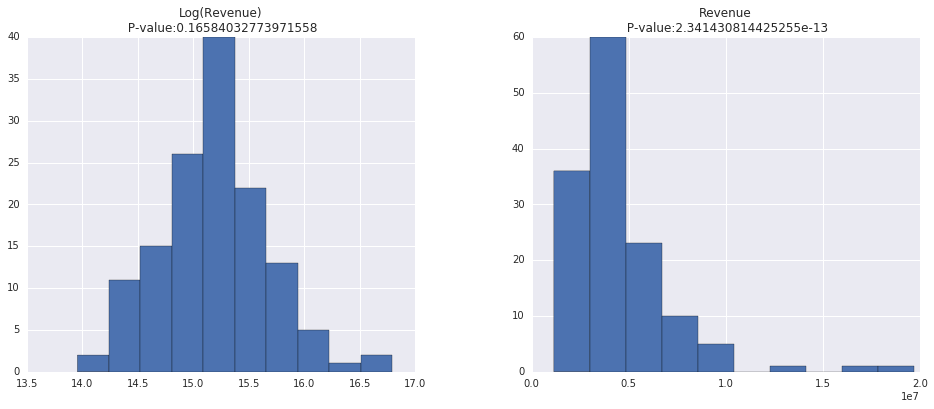

In [510]:
# Check distribution of revenue and log(revenue)
plt.rcParams['figure.figsize'] = (16.0, 6.0)
pvalue_before = shapiro(train["Revenue"])[1]
pvalue_after = shapiro(np.log(train["Revenue"]))[1]
graph_data = pd.DataFrame(
        {
            ("Revenue\n P-value:" + str(pvalue_before)) : train["Revenue"],
            ("Log(Revenue)\n P-value:" + str(pvalue_after)) : np.log(train["Revenue"])
        }
    )
graph_data.hist()

In [511]:
# log transform revenue as it is approximately normal. If this distribution for revenue holds in the test set,
# log transforming the variable before training models will improve performance vastly.
# However, we cannot be completely certain that this distribution will hold in the test set.
train["Revenue"] = np.log(train["Revenue"])

In [512]:
# Convert unknown restaurant types in test data to known restaurant types using KNN
data = adjust_type(data)

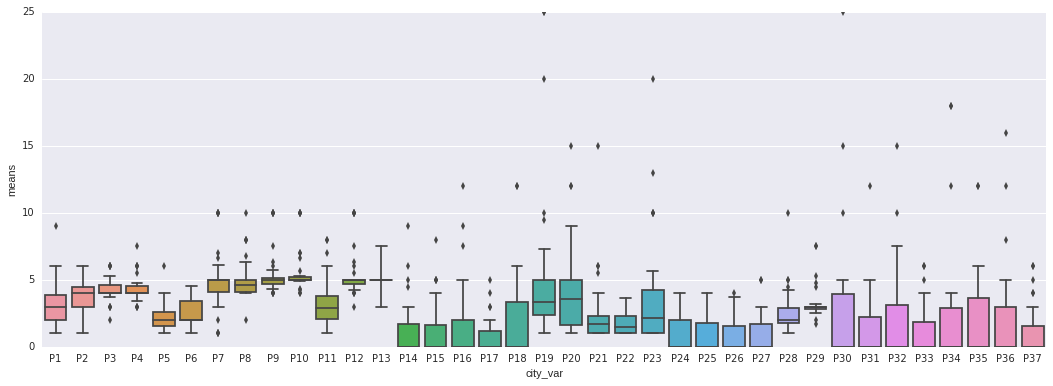

In [513]:
# There is unaccounted problem from City as well.
# Plotting mean of P-variables over each city helps us see which P-variables are highly related to City
# since we are given that one class of P-variables is geographical attributes.
distinct_cities = train.loc[:, "City"].unique()

# Get the mean of each p-variable for each city
means = []
for col in train.columns[5:42]:
    temp = []
    for city in distinct_cities:
        temp.append(train.loc[train.City == city, col].mean())     
    means.append(temp)
    
# Construct data frame for plotting
for i in range(37):
    for j in range(len(distinct_cities)):
        city_pvars.loc[i+37*j] = ["P"+str(i+1), means[i][j]]
        
# Plot boxplot
plt.rcParams['figure.figsize'] = (18.0, 6.0)
sns.boxplot(x="city_var", y="means", data=city_pvars)

# From this we observe that P1, P2, P11, P19, P20, P23, and P30 are approximately a good
# proxy for geographical location.

In [514]:
# Convert unknown cities in test data to clusters based on known cities using KMeans
data = adjust_cities(data, train, 20)

In [515]:
# Do one hot encoding for categorical attributes: restaurant Type and City Group
one_hot_Type = pd.get_dummies(data.loc[:, "Type"])
data["Type_DT"] = one_hot_Type["DT"]
data["Type_FC"] = one_hot_Type["FC"]
data["Type_IL"] = one_hot_Type["IL"]

one_hot_Type = pd.get_dummies(data.loc[:, "City Group"])
data["Big Cities"] = one_hot_Type["Big Cities"]
data["Other"] = one_hot_Type["Other"]

In [516]:
# Drop the now unnecessary attributes
del data["Open Date"]
del data["City"]
del data["City Group"]
del data["Type"]

In [517]:
# Split into train and test datasets
train_processed = data[:num_train]
test_processed = data[num_train:]

In [518]:
# Join revenue of train dataset
train_processed["Revenue"] = train["Revenue"]

In [519]:
def learning_iterate(train_processed, best_rmse):
    
    # Partition train into learning part and validation part in 70% : 30% ratio
    train_randomised = train_processed.iloc[np.random.permutation(train_processed.shape[0])]
    train_learning = train_randomised[:97]
    train_validation = train_randomised[97:]
    
    # Training
    rf_model = random_forest(train_learning, train_validation)
    svm_model = svm_regressor(train_learning, train_validation)
    
    # Inverse log transform on revenue and predictions
    train_validation["Revenue"] = np.exp(train_validation["Revenue"])
    train_validation["Predicted_rf"] = np.exp(train_validation["Predicted_rf"])
    train_validation["Predicted_svm"] = np.exp(train_validation["Predicted_svm"])
    
    # Calculate final prediction by taking average
    train_validation['Prediction_final'] = \
    0.5*(train_validation.loc[:, "Predicted_rf"] + train_validation.loc[:, "Predicted_svm"])
    
    # Calculate final RMSE
    rmse_final = evaluate_rmse(train_validation, "Prediction_final")
    
    # If current RMSE is the least observed so far, perform predtion on test data
    if rmse_final < best_rmse:
        best_rmse = rmse_final
        test_processed["Predicted_rf"] = np.exp(rf_model.predict(test_processed.loc[:, "P1" : "Other"]))
        test_processed["Predicted_svm"] = np.exp(svm_model.predict(test_processed.loc[:, "P1" : "Other"]))
        test_processed["Prediction"] = \
        0.5*(test_processed.loc[:, "Predicted_rf"] + test_processed.loc[:, "Predicted_svm"])
        
    return best_rmse

In [520]:
# Choose best model oven 10 iterations
best_rmse = 10000000000
for i in range(100):
    best_rmse = learning_iterate(train_processed, best_rmse)

In [521]:
# Export results to submission.csv
test_processed.reset_index(inplace=True)
test_processed.loc[:, "Prediction"].to_csv("submission.csv")

In [522]:
best_rmse

1485151.8775167465